In [2]:
import pandas as pd
import numpy as np
import sys

import warnings
import math

df=pd.read_csv('../data/data.csv.gz', compression='gzip', sep=',',header=None)
df['timestamp'] = pd.to_datetime(df[1], format="%Y-%m-%d %H:%M:%S")


In [3]:


stock_delta = df[0] - df[0].shift()
time_delta = (df['timestamp'] - df['timestamp'].shift()).fillna(10000).dt.total_seconds()

In [4]:
stock_split_index=df.index[stock_delta!=0].tolist()
stock_split_index.append(len(df))

In [5]:
stock_split_index

[0,
 22188,
 41022,
 62773,
 82922,
 105187,
 128292,
 150668,
 170116,
 192427,
 211663,
 231961,
 251024,
 272328,
 292863,
 314168,
 334477,
 357031,
 378140,
 395309,
 414888,
 436658,
 456295,
 472398,
 493838,
 515952,
 533436,
 548961,
 570189,
 592766,
 613674]

In [6]:
day_split_index=df.index[abs(time_delta)>36000].tolist()
day_split_index.insert(0, 0)
day_split_index.append(len(df))

In [7]:
day_split_index

[0,
 498,
 982,
 1465,
 1966,
 2455,
 2911,
 3402,
 3871,
 4351,
 4828,
 5320,
 5814,
 6315,
 6814,
 7315,
 7795,
 8270,
 8757,
 9251,
 9726,
 10206,
 10695,
 11176,
 11639,
 12114,
 12574,
 13022,
 13485,
 13976,
 14453,
 14922,
 15391,
 15849,
 16327,
 16821,
 17303,
 17799,
 18297,
 18797,
 19290,
 19769,
 20241,
 20734,
 21209,
 21698,
 22188,
 22596,
 22955,
 23315,
 23756,
 24125,
 24488,
 24844,
 25234,
 25608,
 26016,
 26439,
 26849,
 27320,
 27797,
 28261,
 28686,
 29088,
 29520,
 29997,
 30424,
 30799,
 31160,
 31504,
 31918,
 32299,
 32662,
 33054,
 33393,
 33821,
 34245,
 34626,
 35043,
 35384,
 35808,
 36256,
 36701,
 37155,
 37586,
 38003,
 38433,
 38869,
 39270,
 39668,
 40090,
 40567,
 41022,
 41487,
 41989,
 42474,
 42938,
 43371,
 43814,
 44256,
 44714,
 45139,
 45559,
 45975,
 46406,
 46850,
 47293,
 47729,
 48164,
 48586,
 49084,
 49590,
 50089,
 50595,
 51101,
 51607,
 52109,
 52609,
 53115,
 53620,
 54120,
 54617,
 55115,
 55612,
 56110,
 56602,
 57105,
 57607,
 5

In [8]:
stock_id_list = df[0].unique().tolist()

In [9]:
current_stock_index = 0
time_series_list = []
time_series_all_list = []
for i in range(len(day_split_index) - 1):
    start_index = day_split_index[i]
    end_index = day_split_index[i + 1]
    day_time_series = df.iloc[start_index:end_index]
    time_series_list.append(day_time_series)
    if end_index == stock_split_index[current_stock_index + 1]:
        print("finished stock: {}, got {} time series".format(current_stock_index, len(time_series_list)))
        time_series_all_list.append(time_series_list)
        time_series_list = []
        current_stock_index += 1

finished stock: 0, got 46 time series
finished stock: 1, got 46 time series
finished stock: 2, got 46 time series
finished stock: 3, got 46 time series
finished stock: 4, got 46 time series
finished stock: 5, got 46 time series
finished stock: 6, got 46 time series
finished stock: 7, got 46 time series
finished stock: 8, got 46 time series
finished stock: 9, got 46 time series
finished stock: 10, got 46 time series
finished stock: 11, got 46 time series
finished stock: 12, got 46 time series
finished stock: 13, got 46 time series
finished stock: 14, got 46 time series
finished stock: 15, got 46 time series
finished stock: 16, got 46 time series
finished stock: 17, got 46 time series
finished stock: 18, got 46 time series
finished stock: 19, got 46 time series
finished stock: 20, got 46 time series
finished stock: 21, got 46 time series
finished stock: 22, got 46 time series
finished stock: 23, got 46 time series
finished stock: 24, got 46 time series
finished stock: 25, got 46 time ser

In [11]:
# plot the data
time_series_all_list[2][0]

,0,1,2,3,4,5,6,timestamp
41022,120,2019-01-28 08:00:00+00,211.2,211.6,210.4,210.8,26000,2019-01-28 08:00:00
41023,120,2019-01-28 08:01:00+00,210.8,210.8,210.8,210.8,2,2019-01-28 08:01:00
41024,120,2019-01-28 08:02:00+00,211.0,211.1,210.7,211.1,1013,2019-01-28 08:02:00
41025,120,2019-01-28 08:03:00+00,210.8,210.9,210.7,210.7,166,2019-01-28 08:03:00
41026,120,2019-01-28 08:04:00+00,210.8,211.0,210.8,210.8,1077,2019-01-28 08:04:00
41027,120,2019-01-28 08:05:00+00,210.8,211.0,210.8,210.8,1836,2019-01-28 08:05:00
41028,120,2019-01-28 08:06:00+00,211.0,211.0,210.7,210.7,1626,2019-01-28 08:06:00
41029,120,2019-01-28 08:07:00+00,210.8,210.8,210.8,210.8,1352,2019-01-28 08:07:00
41030,120,2019-01-28 08:08:00+00,210.7,210.8,210.6,210.8,2302,2019-01-28 08:08:00
41031,120,2019-01-28 08:09:00+00,210.9,211.0,210.6,210.7,3588,2019-01-28 08:09:00


In [15]:
 ts = pd.Series(time_series_all_list[2][0][5], index=time_series_all_list[2][0]['timestamp'])


In [43]:
time_series_all_list[2][0]['sma_10']=time_series_all_list[2][0][5].rolling(window=10).mean()
time_series_all_list[2][0]['ema_10'] = time_series_all_list[2][0][5].ewm(span=10, adjust=False).mean()
time_series_all_list[2][0]['ema_20'] = time_series_all_list[2][0][5].ewm(span=20, adjust=False).mean()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

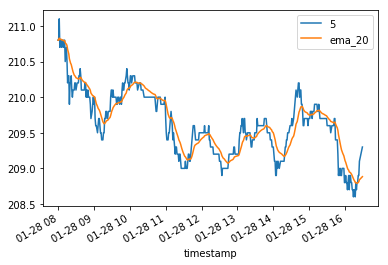

In [44]:
time_series_all_list[2][0].plot(x='timestamp', y=[5,'ema_20'])



In [47]:

diff=time_series_all_list[2][0][5].diff()[1:]/time_series_all_list[2][0][5]

In [48]:
diff

41022         NaN
41023    0.000000
41024    0.001421
41025   -0.001898
41026    0.000474
41027    0.000000
41028   -0.000475
41029    0.000474
41030    0.000000
41031   -0.000475
41032    0.000474
41033    0.000000
41034   -0.001425
41035    0.000475
41036    0.000475
41037   -0.000950
41038   -0.001427
41039    0.000476
41040    0.000000
41041   -0.001906
41042    0.001427
41043    0.000000
41044    0.000476
41045   -0.000952
41046   -0.000476
41047    0.000476
41048    0.000000
41049    0.000000
41050    0.000476
41051    0.000000
           ...   
41457    0.000000
41458    0.000000
41459    0.000000
41460   -0.000958
41461    0.000000
41462    0.000479
41463   -0.000479
41464    0.000000
41465   -0.000479
41466    0.000479
41467    0.000479
41468   -0.000958
41469    0.000957
41470    0.000000
41471   -0.000479
41472    0.000000
41473   -0.000479
41474    0.000000
41475   -0.000479
41476    0.000479
41477    0.000000
41478   -0.000479
41479    0.000958
41480   -0.000479
41481    0